# Practical example on how to use this asset


## Create your child class 
The first thing to do is to create a class that inherets the one in MLFeatureSelection module.

You need to implement the function **build_model()** and prepare you date to suit your use case.

# Crossvalidation method

In [1]:
!pip install poetry --quiet
!poetry build

Building mlfeatureselection (2.3)
  - Building sdist
  - Built mlfeatureselection-2.3.tar.gz
  - Building wheel
  - Built mlfeatureselection-2.3-py3-none-any.whl


In [3]:
!pip install ../dist/mlfeatureselection-2.3-py3-none-any.whl --quiet

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn import metrics
from random import shuffle
from feature_selection.selectors import FeatureSelector
from logzero import logger
import logging

class testFeatureSelector(FeatureSelector):
    def __init__(self, df, target_col, log_level=logging.INFO, custom_cv=None):
        FeatureSelector.__init__(self, df, target_col, log_level)
    
    def build_model(self):
        """
        Define your model here and return a model instance that implements "fit" method
        """
        params = {
            'seed': 2020,
            'learning_rate': 0.01,
            'n_estimators': 400,
            'max_depth': 4,
            'subsample': 0.7,
            'colsample_bytree': 0.7
        }
        
        clf = xgb.XGBClassifier(**params)
        return clf

    

### Make you data ready for the training

In [6]:
path = "Placement_Data_Full_Class.csv"

df = pd.read_csv(path)
list_columns = list(df.columns)
shuffle(list_columns)
df = df[list_columns]
df.loc[df['status'] == 'Placed', 'status'] = 1
df.loc[df['status'] == 'Not Placed', 'status'] = 0
df["status"]=df["status"].astype('int')
df.drop(['salary', 'sl_no'], axis=1, inplace = True)

cat_vars = ['workex', 'specialisation', 'gender', 'ssc_b', 'hsc_s', 'hsc_b', "degree_t"]

categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('OrdEnc', OrdinalEncoder())])

df[cat_vars] = categorical_transformer.fit_transform(df[cat_vars])
df.head()

,gender,hsc_b,etest_p,workex,degree_p,hsc_p,ssc_b,ssc_p,mba_p,specialisation,hsc_s,status,degree_t
0,1.0,1.0,55.0,0.0,58.00,91.00,1.0,67.00,58.80,1.0,1.0,1,2.0
1,1.0,1.0,86.5,1.0,77.48,78.33,0.0,79.33,66.28,0.0,2.0,1,2.0
2,1.0,0.0,75.0,0.0,64.00,68.00,0.0,65.00,57.80,0.0,0.0,1,0.0
3,1.0,0.0,66.0,0.0,52.00,52.00,0.0,56.00,59.43,1.0,2.0,0,2.0
4,1.0,0.0,96.8,0.0,73.30,73.60,0.0,85.80,55.50,0.0,1.0,1,0.0


### Testing the features selection

In [10]:
f = testFeatureSelector(df=df, target_col='status', log_level=logging.DEBUG)
list_kept_features, features_impact = f.feature_selection_cv(small_is_better=False, scoring_metric='roc_auc', cv=20)

print(f"List of kept feature {list_kept_features}, {len(list_kept_features)} out of {df.shape[1] - 1}")

[I 201109 16:28:30 selectors:214] Starting score 0.9324150049563251
[D 201109 16:28:32 selectors:231] Old score 0.9324150049563251, new score 0.9306507564504265
[D 201109 16:28:32 selectors:257] The model is worse ==> keep gender
[D 201109 16:28:35 selectors:231] Old score 0.9324150049563251, new score 0.9329875405346678
[D 201109 16:28:35 selectors:242] Improvement or nothing changed ==> delete hsc_b
[I 201109 16:28:38 selectors:254] New base line score: 0.9329875405346678
[D 201109 16:28:38 selectors:147] list of deleted features : ['hsc_b']
[D 201109 16:28:41 selectors:231] Old score 0.9329875405346678, new score 0.9358281443645403
[D 201109 16:28:41 selectors:242] Improvement or nothing changed ==> delete etest_p
[I 201109 16:28:44 selectors:254] New base line score: 0.9358281443645403
[D 201109 16:28:44 selectors:147] list of deleted features : ['hsc_b', 'etest_p']
[D 201109 16:28:47 selectors:231] Old score 0.9358281443645403, new score 0.9269069589989707
[D 201109 16:28:47 selec

List of kept feature Index(['gender', 'workex', 'degree_p', 'hsc_p', 'ssc_p', 'mba_p',
       'specialisation', 'hsc_s', 'degree_t'],
      dtype='object'), 9 out of 12


What you can notice here is that the AUC improved when dropping some columns from **0.930 --> 0.935**

### Testing the features selection with fast_vesion **Only available for xgboost**

Use the argument `fast_version=True` in order to activate an accelerator that uses the feature_importance of xgboost to filter out the bottom features ordered by gain. 

The parameter`nb_ft` will be used to select features to experiment on after the first training of the model.

In [6]:
path = "Placement_Data_Full_Class.csv"
f = testFeatureSelector(df=df, target_col='status', log_level=logging.DEBUG)
%time list_kept_features, features_impact = f.featureSelectionCV(small_is_better=False, scoring_metric='roc_auc', cv=20, fast_version=True, nb_ft=7)

print(f"List of kept feature {list_kept_features}, {len(list_kept_features)} out of {df.shape[1] - 1}")

[D 201109 13:29:28 selectors:139] list of deleted features : ['hsc_s', 'ssc_b']
[I 201109 13:29:28 selectors:188] Starting score 0.9319841937570731
[D 201109 13:29:31 selectors:201] Old score 0.9319841937570731, new score 0.9339359923791417
[D 201109 13:29:31 selectors:204] Improvement or nothing changed ==> delete hsc_b
[I 201109 13:29:34 selectors:212] New base line score: 0.9339359923791417
[D 201109 13:29:34 selectors:139] list of deleted features : ['hsc_s', 'ssc_b', 'hsc_b']
[D 201109 13:29:36 selectors:201] Old score 0.9339359923791417, new score 0.9317701368656561
[D 201109 13:29:36 selectors:215] The model is worse ==> keep gender
[D 201109 13:29:39 selectors:201] Old score 0.9339359923791417, new score 0.9333070480852012
[D 201109 13:29:39 selectors:215] The model is worse ==> keep degree_t
[D 201109 13:29:42 selectors:201] Old score 0.9339359923791417, new score 0.9312735225294254
[D 201109 13:29:42 selectors:215] The model is worse ==> keep specialisation
[D 201109 13:29:45

CPU times: user 6min 17s, sys: 17 s, total: 6min 34s
Wall time: 39 s
List of kept feature Index(['gender', 'degree_t', 'specialisation', 'workex', 'ssc_p', 'hsc_p',
       'degree_p', 'mba_p'],
      dtype='object'), 8 out of 12


### Use your own Cross-Validation function

The class must implement split that yields `x_train, y_train, x_test, y_test`
In the example bellow, we are stratifying the kfolds using a column "groups"

**Note**: the framework uses the inner function `split(X, y)`, if other parameters are required they should be added in
the custom class like we've donne here with `groups`. 

In [7]:
from sklearn.model_selection import StratifiedKFold


class CustomGroupSplit(StratifiedKFold):
    
    def __init__(self, groups, n_splits, random_state):
        super(CustomGroupSplit, self).__init__(n_splits=n_splits, random_state=random_state)
        self.groups = groups
    
    def split(self, X, y, groups=None):
        return super(CustomGroupSplit, self).split(X, y, self.groups)

In [8]:
custom_cv = CustomGroupSplit(groups=df.gender, n_splits=20, random_state=2020)
    
path = "Placement_Data_Full_Class.csv"
f = testFeatureSelector(df=df, target_col='status', log_level=logging.DEBUG, custom_cv=custom_cv)
%time list_kept_features, features_impact = f.featureSelectionCV(small_is_better=False, scoring_metric='roc_auc', cv=20, fast_version=True, nb_ft=7)

print(f"List of kept feature {list_kept_features}, {len(list_kept_features)} out of {df.shape[1] - 1}")

/Users/mehditantaoui/anaconda3/envs/persodev/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[D 201109 13:30:07 selectors:139] list of deleted features : ['hsc_s', 'ssc_b']
[I 201109 13:30:07 selectors:188] Starting score 0.9319841937570731
[D 201109 13:30:09 selectors:201] Old score 0.9319841937570731, new score 0.9339359923791417
[D 201109 13:30:09 selectors:204] Improvement or nothing changed ==> delete hsc_b
[I 201109 13:30:11 selectors:212] New base line score: 0.9339359923791417
[D 201109 13:30:11 selectors:139] list of deleted features : ['hsc_s', 'ssc_b', 'hsc_b']
[D 201109 13:30:14 selectors:201] Old score 0.9339359923791417, new score 0.9317701368656561
[D 201109 13:30:14 selectors:215] The model is worse ==> keep gender
[D 201109 13:30:16 selectors:201] Old sc

CPU times: user 5min 32s, sys: 13.1 s, total: 5min 46s
Wall time: 33.2 s
List of kept feature Index(['gender', 'degree_t', 'specialisation', 'workex', 'ssc_p', 'hsc_p',
       'degree_p', 'mba_p'],
      dtype='object'), 8 out of 12


### Analyse your features impact 

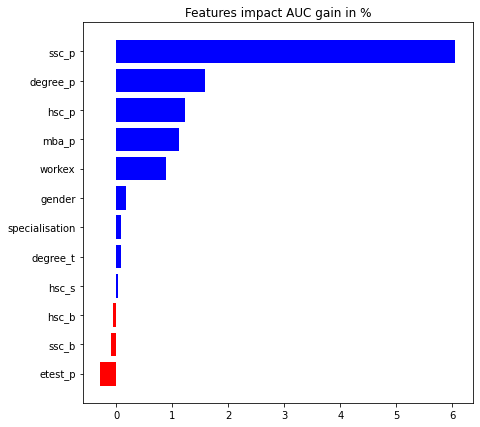

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

ft_impact = pd.DataFrame(features_impact).sort_values('roc_auc gain', ascending=True)
_ = plt.figure(figsize=(7,7))
plt.barh(ft_impact.feature, ft_impact['roc_auc gain']*100, color=(ft_impact['roc_auc gain']>0).map({True: 'b', False: 'r'}))
plt.title("Features impact: AUC gain in %")
plt.show()

# Working with Sklearn Pipelines

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn import metrics
from random import shuffle
from feature_selection.selectors import FeatureSelector
from logzero import logger
import logging

class testFeatureSelector(FeatureSelector):
    def __init__(self, df, target_col, log_level=logging.INFO):
        FeatureSelector.__init__(self, df, target_col, log_level)
        self.current_col_candidate = ''
        
    
    def action_on_update(self, cols_to_drop):
        # Here we add the current col so that it can be removed from the pipeline
        self.current_col_candidate = cols_to_drop[0]
    
    def build_model(self):
        """
        Define your model here and return a model instance that implements "fit" method
        """
        params = {
            'seed': 2020,
            'learning_rate': 0.01,
            'n_estimators': 400,
            'max_depth': 4,
            'subsample': 0.7,
            'colsample_bytree': 0.7
        }
        
        cat_vars = ['workex', 'specialisation', 'gender', 'ssc_b', 'hsc_s', 'hsc_b', "degree_t"]
        num_vars = ['degree_p', 'ssc_p', 'etest_p', 'mba_p', 'hsc_p']
        
        # Transformer for numerical variables
        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())])

        # Transformer for categorical variables
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant')),
            ('OrdEnc', OrdinalEncoder())])

        # Here we update the num_vars and cat_vars:
        # list_of_deleted_col: inner object refering to columns already deleted
        # current_col_candidate: string that refers to the current column being evaluated.
        # We make sure that none of the two above are in num_vars nor cat_vars
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, [col for col in num_vars if (col not in self.list_of_deleted_col) and col != self.current_col_candidate]),
                ('cat', categorical_transformer, [col for col in cat_vars if (col not in self.list_of_deleted_col) and col != self.current_col_candidate])])

        clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', xgb.XGBClassifier(**params))])
        return clf

    

### Make you data ready for the training

In [11]:
path = "Placement_Data_Full_Class.csv"

df = pd.read_csv(path)
list_columns = list(df.columns)
shuffle(list_columns)
df = df[list_columns]
df.loc[df['status'] == 'Placed', 'status'] = 1
df.loc[df['status'] == 'Not Placed', 'status'] = 0
df["status"]=df["status"].astype('int')
df.drop(['salary', 'sl_no'], axis=1, inplace = True)

df.head()

,degree_t,gender,hsc_b,mba_p,workex,hsc_s,specialisation,status,etest_p,ssc_p,degree_p,hsc_p,ssc_b
0,Sci&Tech,M,Others,58.80,No,Commerce,Mkt&HR,1,55.0,67.00,58.00,91.00,Others
1,Sci&Tech,M,Others,66.28,Yes,Science,Mkt&Fin,1,86.5,79.33,77.48,78.33,Central
2,Comm&Mgmt,M,Central,57.80,No,Arts,Mkt&Fin,1,75.0,65.00,64.00,68.00,Central
3,Sci&Tech,M,Central,59.43,No,Science,Mkt&HR,0,66.0,56.00,52.00,52.00,Central
4,Comm&Mgmt,M,Central,55.50,No,Commerce,Mkt&Fin,1,96.8,85.80,73.30,73.60,Central


In [ ]:
f = testFeatureSelector(df=df, target_col='status', log_level=logging.DEBUG)
%time list_kept_features, features_impact = f.featureSelectionCV(small_is_better=False, scoring_metric='roc_auc', cv=20)

print(f"List of kept feature {list_kept_features}, {len(list_kept_features)} out of {df.shape[1] - 1}")

[D 201109 13:30:36 selectors:161] Working with sklearn pipeline, model type: <class 'xgboost.sklearn.XGBClassifier'>
[I 201109 13:30:40 selectors:188] Starting score 0.9328198608838942
[D 201109 13:30:43 selectors:201] Old score 0.9328198608838942, new score 0.9316680516101263
[D 201109 13:30:43 selectors:215] The model is worse ==> keep degree_t
[D 201109 13:30:46 selectors:201] Old score 0.9328198608838942, new score 0.9301846905228321
[D 201109 13:30:46 selectors:215] The model is worse ==> keep gender
[D 201109 13:30:49 selectors:201] Old score 0.9328198608838942, new score 0.9333692327023206
[D 201109 13:30:49 selectors:204] Improvement or nothing changed ==> delete hsc_b
[I 201109 13:30:52 selectors:212] New base line score: 0.9333692327023206
[D 201109 13:30:52 selectors:139] list of deleted features : ['hsc_b']
